In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
from datetime import datetime, date
df.index = pd.to_datetime(df.Date, format = '%d/%m/%Y', )
df = df.drop(['Date'], axis=1)
df.head()

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [68]:
df.iloc[:,1]

Date
2009-01-01   -31.14
2009-01-02   -31.11
2009-01-03   -31.07
2009-01-04   -31.05
2009-01-05   -31.01
              ...  
2020-06-26   -25.07
2020-06-27   -25.11
2020-06-28   -25.19
2020-06-29   -25.18
2020-06-30   -25.25
Name: Depth_to_Groundwater, Length: 4199, dtype: float64

In [10]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

In [11]:
depth = df['Depth_to_Groundwater']
temp = df['Temperature']
rain = df['Rainfall']
drain = df['Drainage_Volume']
hydro = df['River_Hydrometry']

In [12]:
def split_data(df):
    testSize = 100
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test

In [240]:
train_rain, test_rain = split_data(rain)
train_drain, test_drain = split_data(drain)
train_depth, test_depth = split_data(depth)
train_hydro, test_hydro = split_data(hydro)
train_temp, test_temp = split_data(temp)
train = [train_rain,train_depth,train_temp,train_drain,train_hydro]
test = [test_rain,test_depth,test_temp,test_drain,test_hydro]

In [14]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
def get_order(sr):
    stepwise_fit = auto_arima(sr, suppress_warnings=True)
    return stepwise_fit.order
order = []
for i in range(5):
    order.append(get_order(train[i]))

In [15]:
def fit_arima(df, index):
    model=ARIMA(df,order=order[index])
    model=model.fit()
    return model

In [16]:
model_rain = fit_arima(train_rain, 0)
model_drain = fit_arima(train_drain, 1)
model_temp = fit_arima(train_temp, 2)
model_hydro = fit_arima(train_hydro, 3)
model_depth = fit_arima(train_depth, 4)

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was 

In [17]:
models= np.array([model_rain,model_depth,model_temp,model_drain,model_hydro])

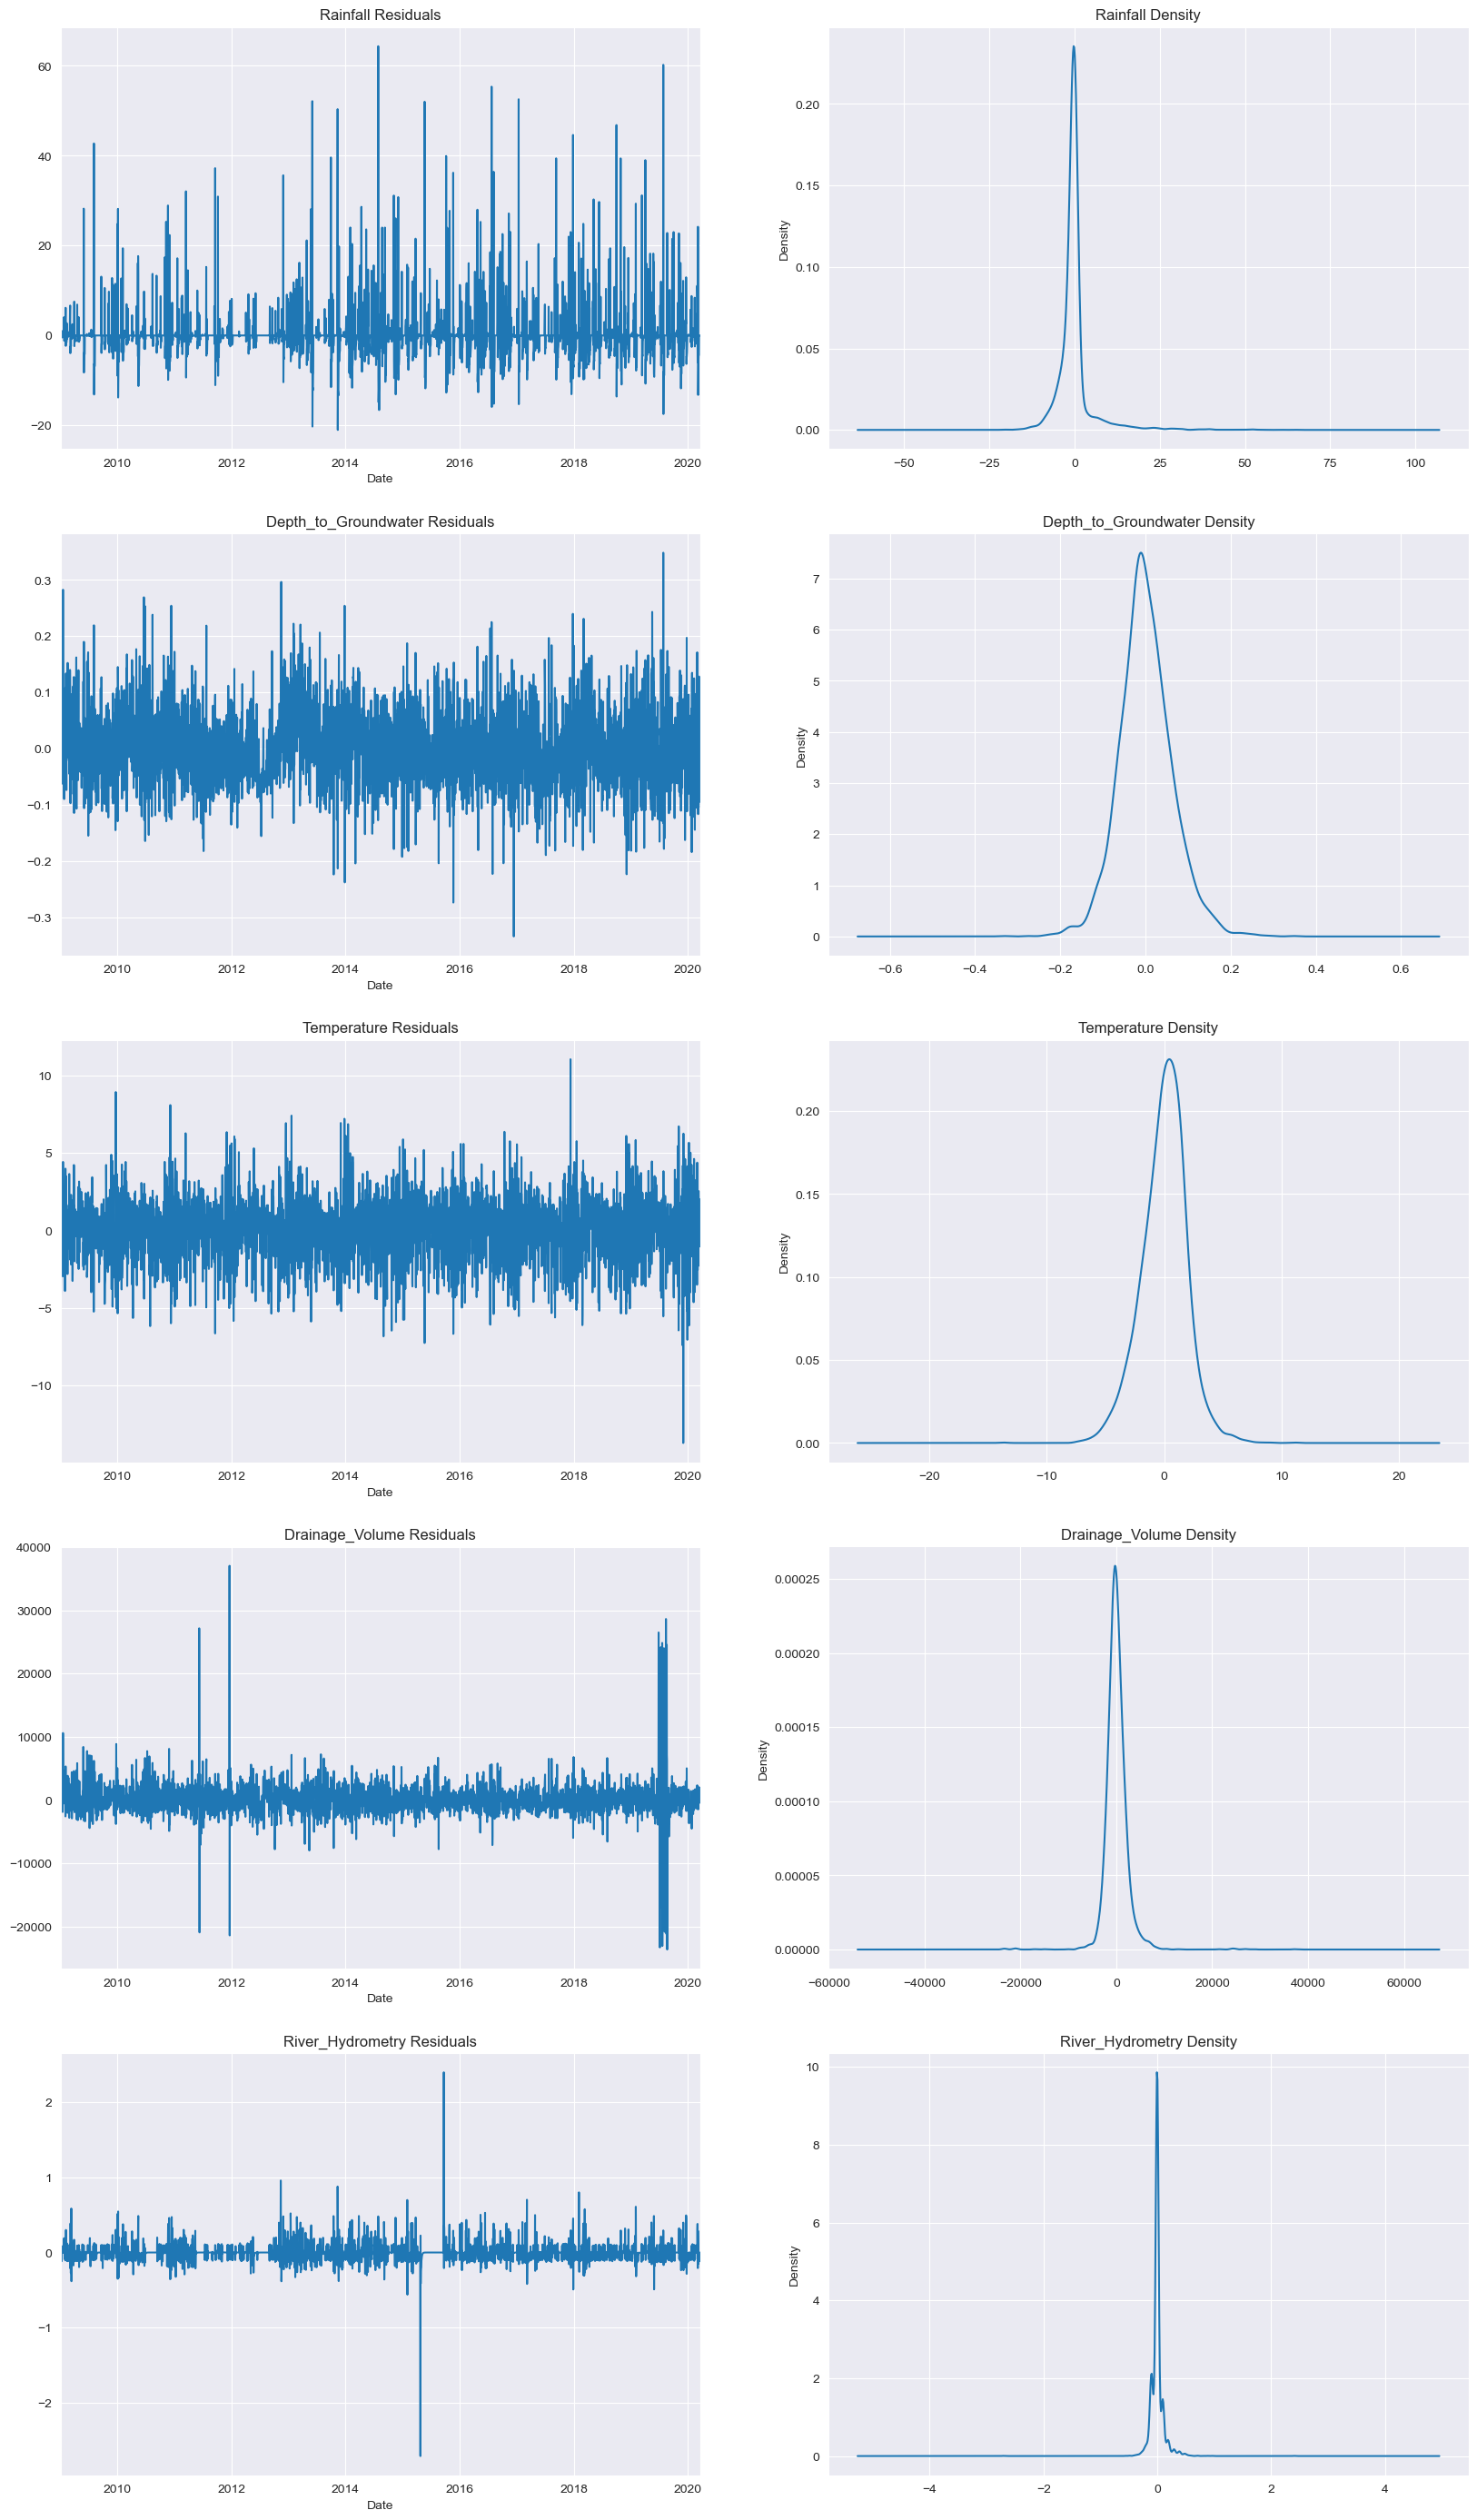

In [18]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 35))
for model in range(0,5):
    residuals =models[model].resid[1:]
    residuals.plot(title= train[model].name + ' Residuals', ax=ax[model,0])
    residuals.plot(title=train[model].name + ' Density', kind='kde', ax=ax[model,1])
plt.show()

<Axes: xlabel='Date'>

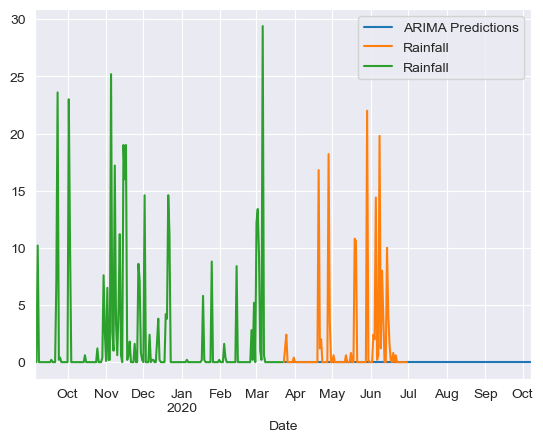

In [19]:
start=len(train[0])
end=len(train[0])+len(test[0])-1
p=models[0].predict(start=start,end=end+100,typ='levels').rename('ARIMA Predictions')
p.plot(legend=True)
test[0].plot(legend=True)
train[0][-200:].plot(legend=True)

In [20]:
type(train)

list

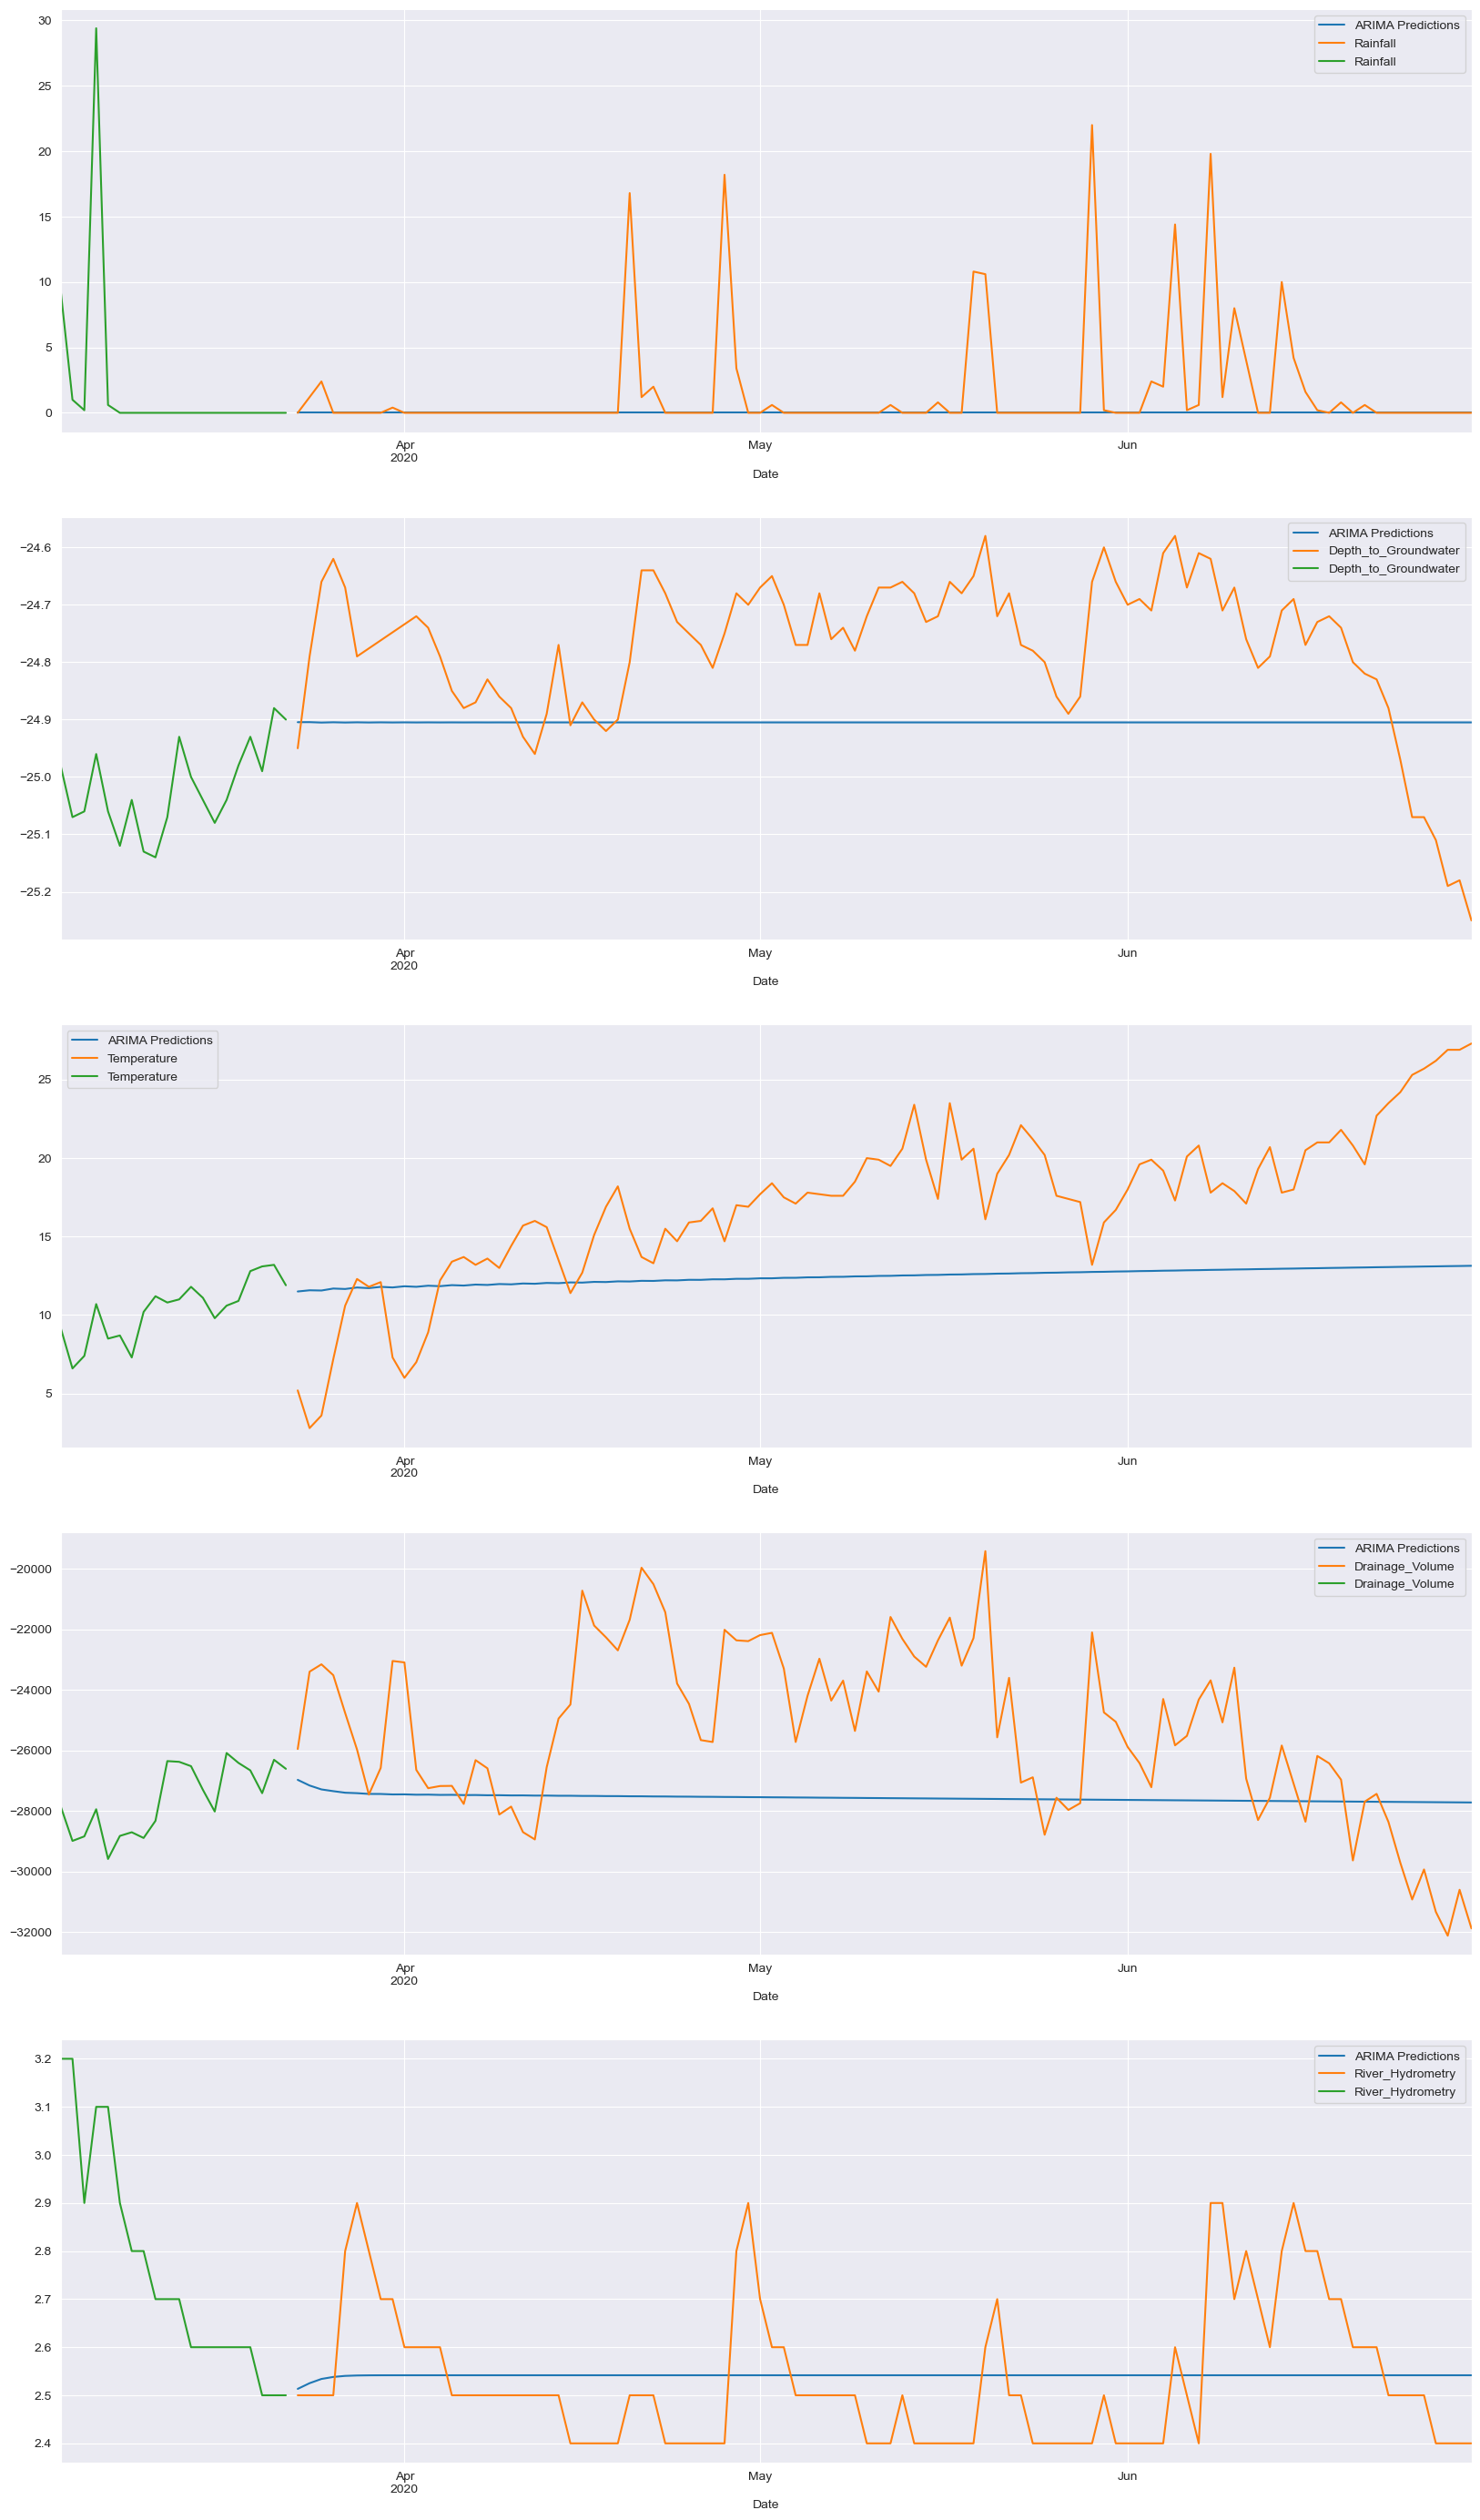

In [271]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
pred = [None] * 5
#forecast_test = [None] * 5
for model in range(0,5):
    start=len(train[model])
    end=len(train[model])+len(test[model])-1
    pred[model]=models[model].predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
    #forecast_test[model] = models[model].forecast(len(test[model]))
    pred[model].plot(ax = ax[model], legend=True)
    test[model].plot(ax = ax[model], legend=True)
    train[model][-20:].plot(ax = ax[model], legend=True)
    #forecast_test[model].plot(ax = ax[model], legend=True)
plt.show()

In [260]:
# Rolling ARIMA algorithm

def arima_roll(df, index):
    train, test = split_data(df)
    history = train.copy()
    predictions = pd.Series([])
    for t in range(len(test)):
        model = fit_arima(history, index)
        hat = model.forecast()
        predictions = pd.concat([predictions, hat])
        history.append(pd.Series(test[t], index=[test.index[t]]))
        #history = pd.concat([history, hat])
    return predictions

In [298]:
def arima_roll(df, index, forecast_steps=5):
    train, test = split_data(df)
    history = train.copy()
    predictions_list = []

    for t in range(len(test)):
        model = fit_arima(history, index)

        # Forecast 'forecast_steps' days ahead
        hat = model.forecast(steps=forecast_steps)

        predictions_list.append(hat)
        history = history.copy()
        history = history.append(pd.Series(test[t], index=[test.index[t]]))

    return predictions_list

In [299]:
result_list = []
for index_value in range(5):
    preds_roll = arima_roll(df.iloc[:,index_value], index_value)
    result_list.append(preds_roll)

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was 

In [306]:
result_list[0][5]

2020-03-28    0.502068
2020-03-29    0.673148
2020-03-30    0.791279
2020-03-31    0.740237
2020-04-01    0.485693
Freq: D, Name: predicted_mean, dtype: float64

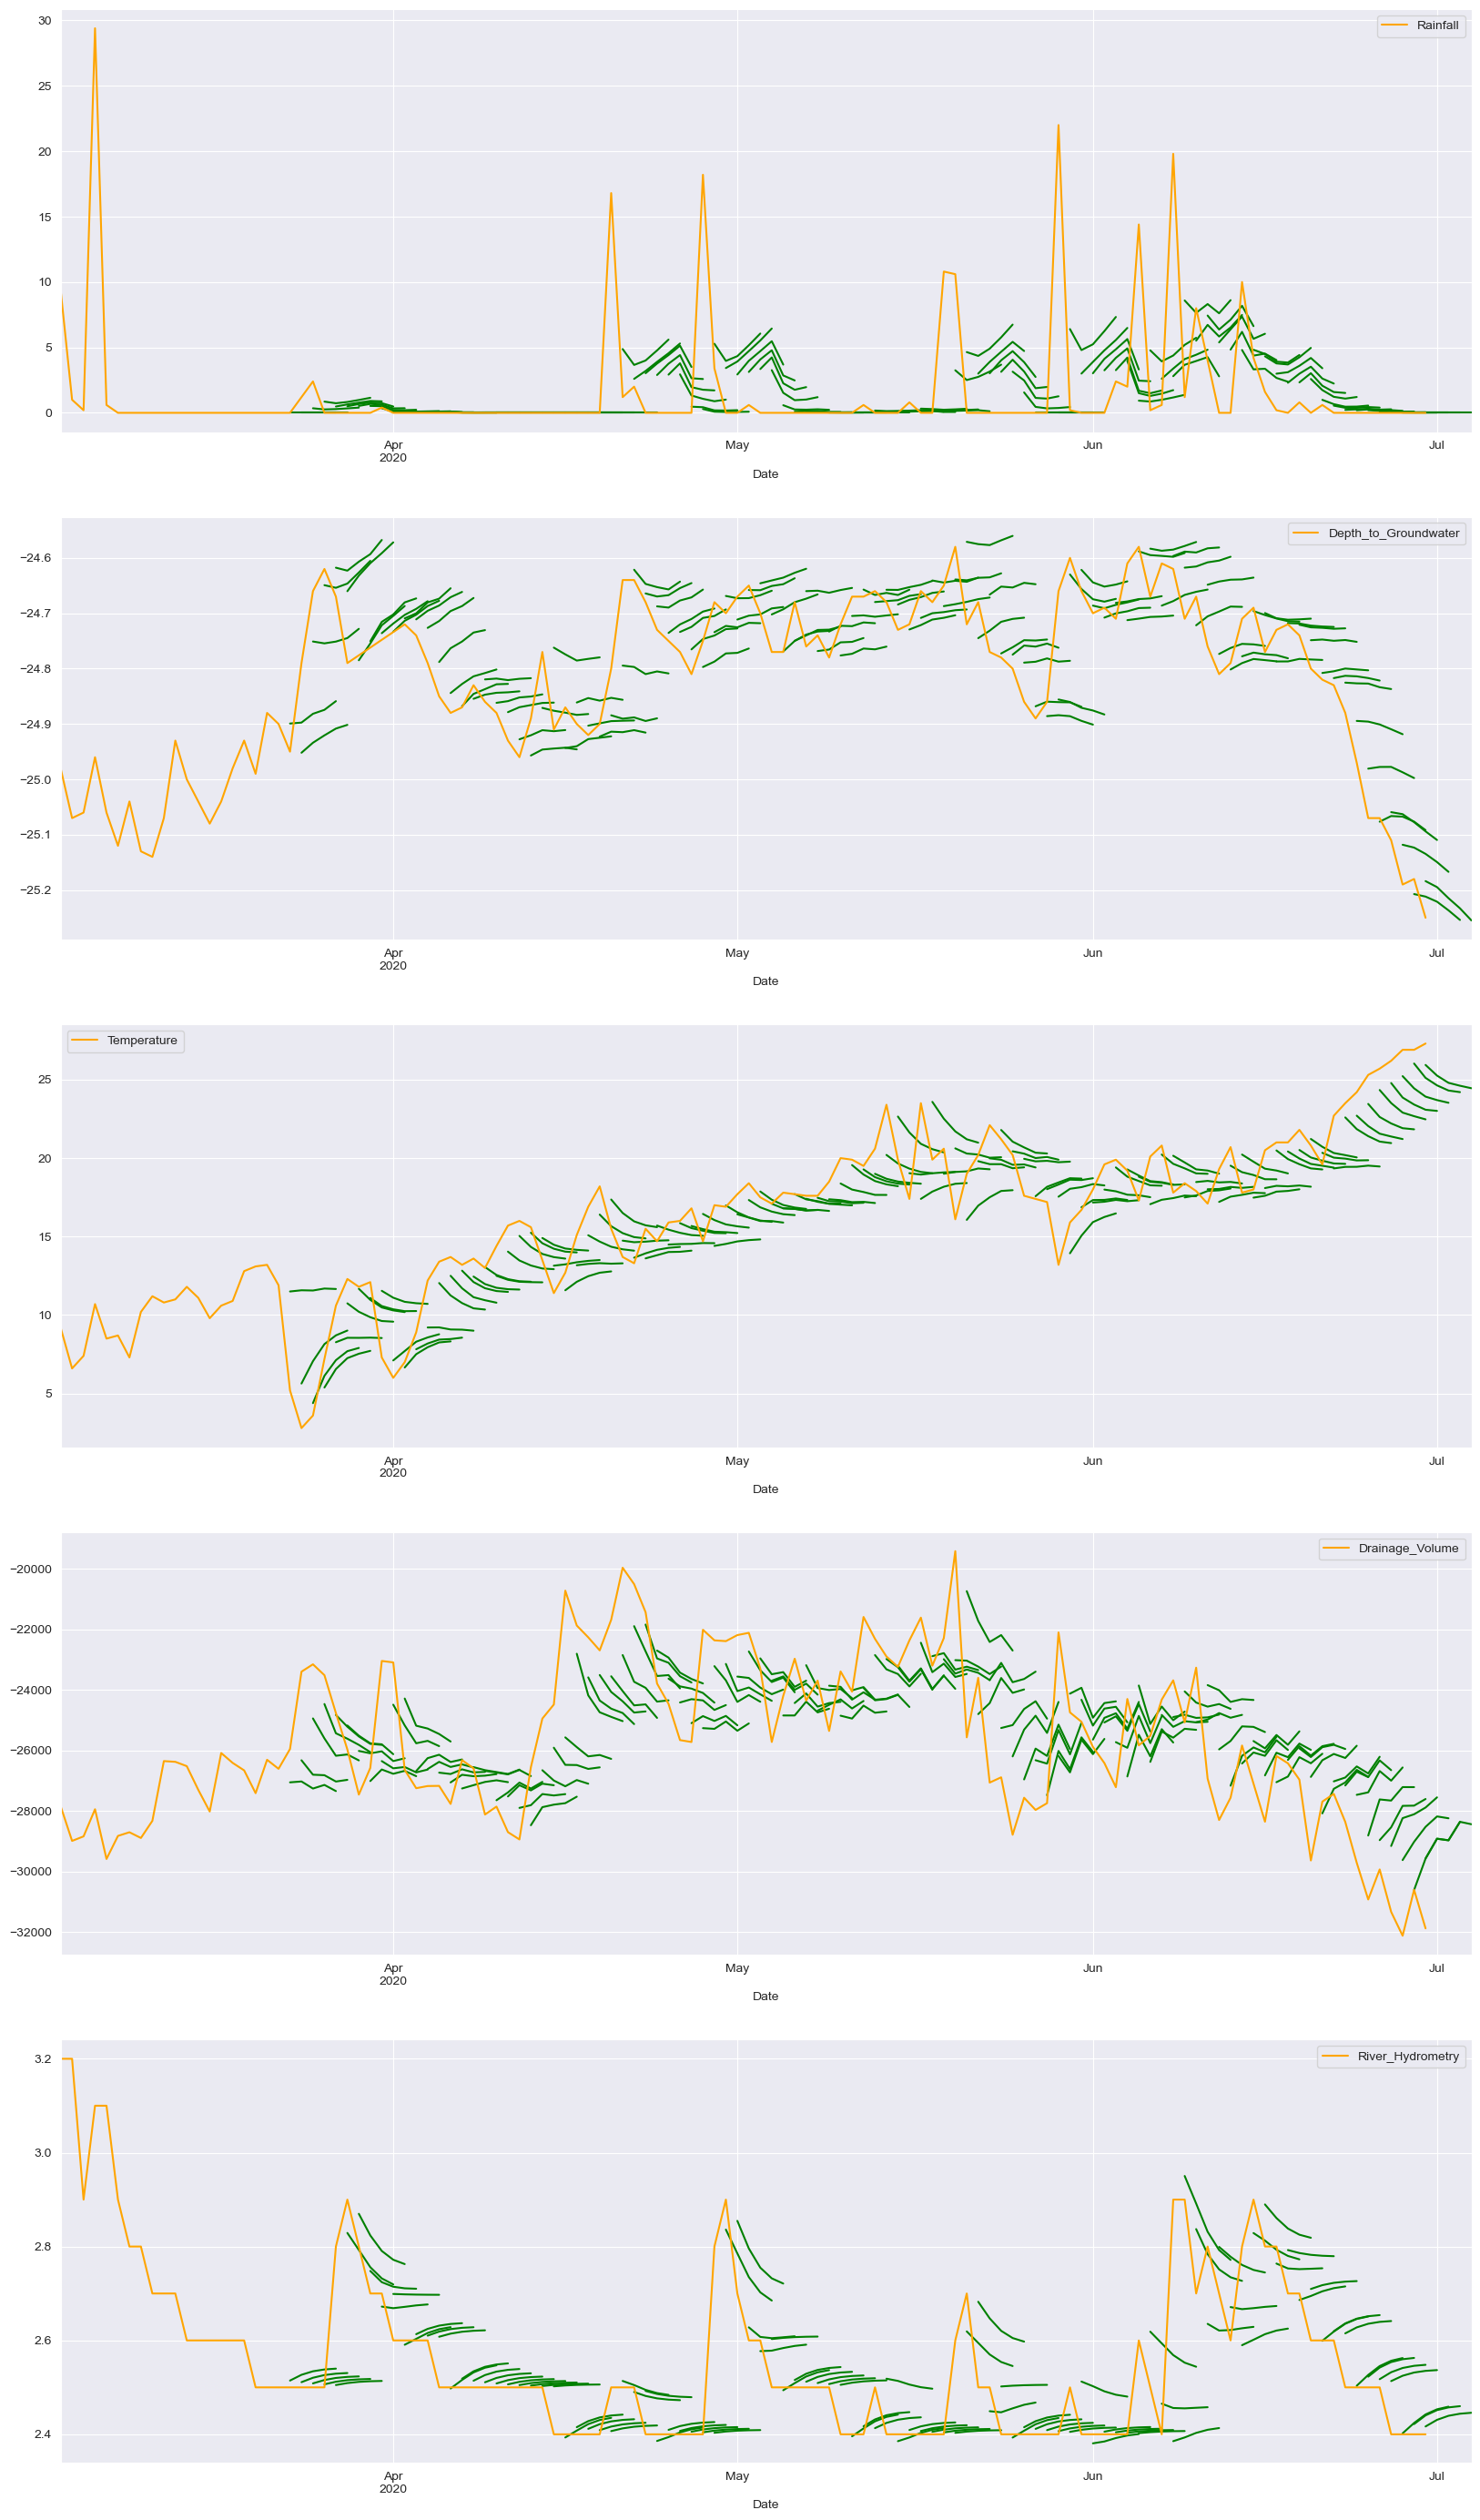

In [312]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
for i in range(5):
    for j in range(len(result_list[i])):
        result_list[i][j].plot(ax = ax[i], label='prediction', color= 'green',legend=False)
    df.iloc[-120:,i].plot(ax = ax[i], color= 'orange', legend=True)
plt.show()

In [160]:
type(result_list)

list

In [263]:
combined_dataframe = pd.concat(result_list, axis=1)

In [264]:
combined_dataframe

,0,1,2,3,4
2020-03-23,-6.767834e-34,-24.899193,11.503811,-27051.691522,2.514475
2020-03-24,-1.205163e-34,-24.898213,11.579783,-27022.447876,2.526766
2020-03-25,-1.070693e-34,-24.886160,11.565267,-27256.860262,2.534262
2020-03-26,-1.392752e-34,-24.875209,11.690619,-27136.499041,2.538135
2020-03-27,-1.701379e-34,-24.860938,11.661698,-27340.395079,2.539902
...,...,...,...,...,...
2020-06-26,-1.839603e-34,-23.903160,12.991478,-27483.988167,2.540906
2020-06-27,-1.839603e-34,-23.891800,13.001889,-27484.022697,2.540906
2020-06-28,-1.839603e-34,-23.881717,13.015089,-27483.823042,2.540906
2020-06-29,-1.839603e-34,-23.870370,13.025120,-27484.128352,2.540906


In [265]:
combined_dataframe.to_csv('predictions2.csv', header=False)

In [308]:
saved_df = pd.read_csv('predictions.csv', header=None, parse_dates=[0], index_col=0)

In [267]:
saved_df

,1,2,3,4,5
0,,,,,
2020-03-23,-6.767834e-34,-24.899193,11.503811,-27051.691522,2.514475
2020-03-24,-1.205163e-34,-24.898213,11.579783,-27022.447876,2.526766
2020-03-25,-1.070693e-34,-24.886160,11.565267,-27256.860262,2.534262
2020-03-26,-1.392752e-34,-24.875209,11.690619,-27136.499041,2.538135
2020-03-27,-1.701379e-34,-24.860938,11.661698,-27340.395079,2.539902
...,...,...,...,...,...
2020-06-26,-1.839603e-34,-23.903160,12.991478,-27483.988167,2.540906
2020-06-27,-1.839603e-34,-23.891800,13.001889,-27484.022697,2.540906
2020-06-28,-1.839603e-34,-23.881717,13.015089,-27483.823042,2.540906


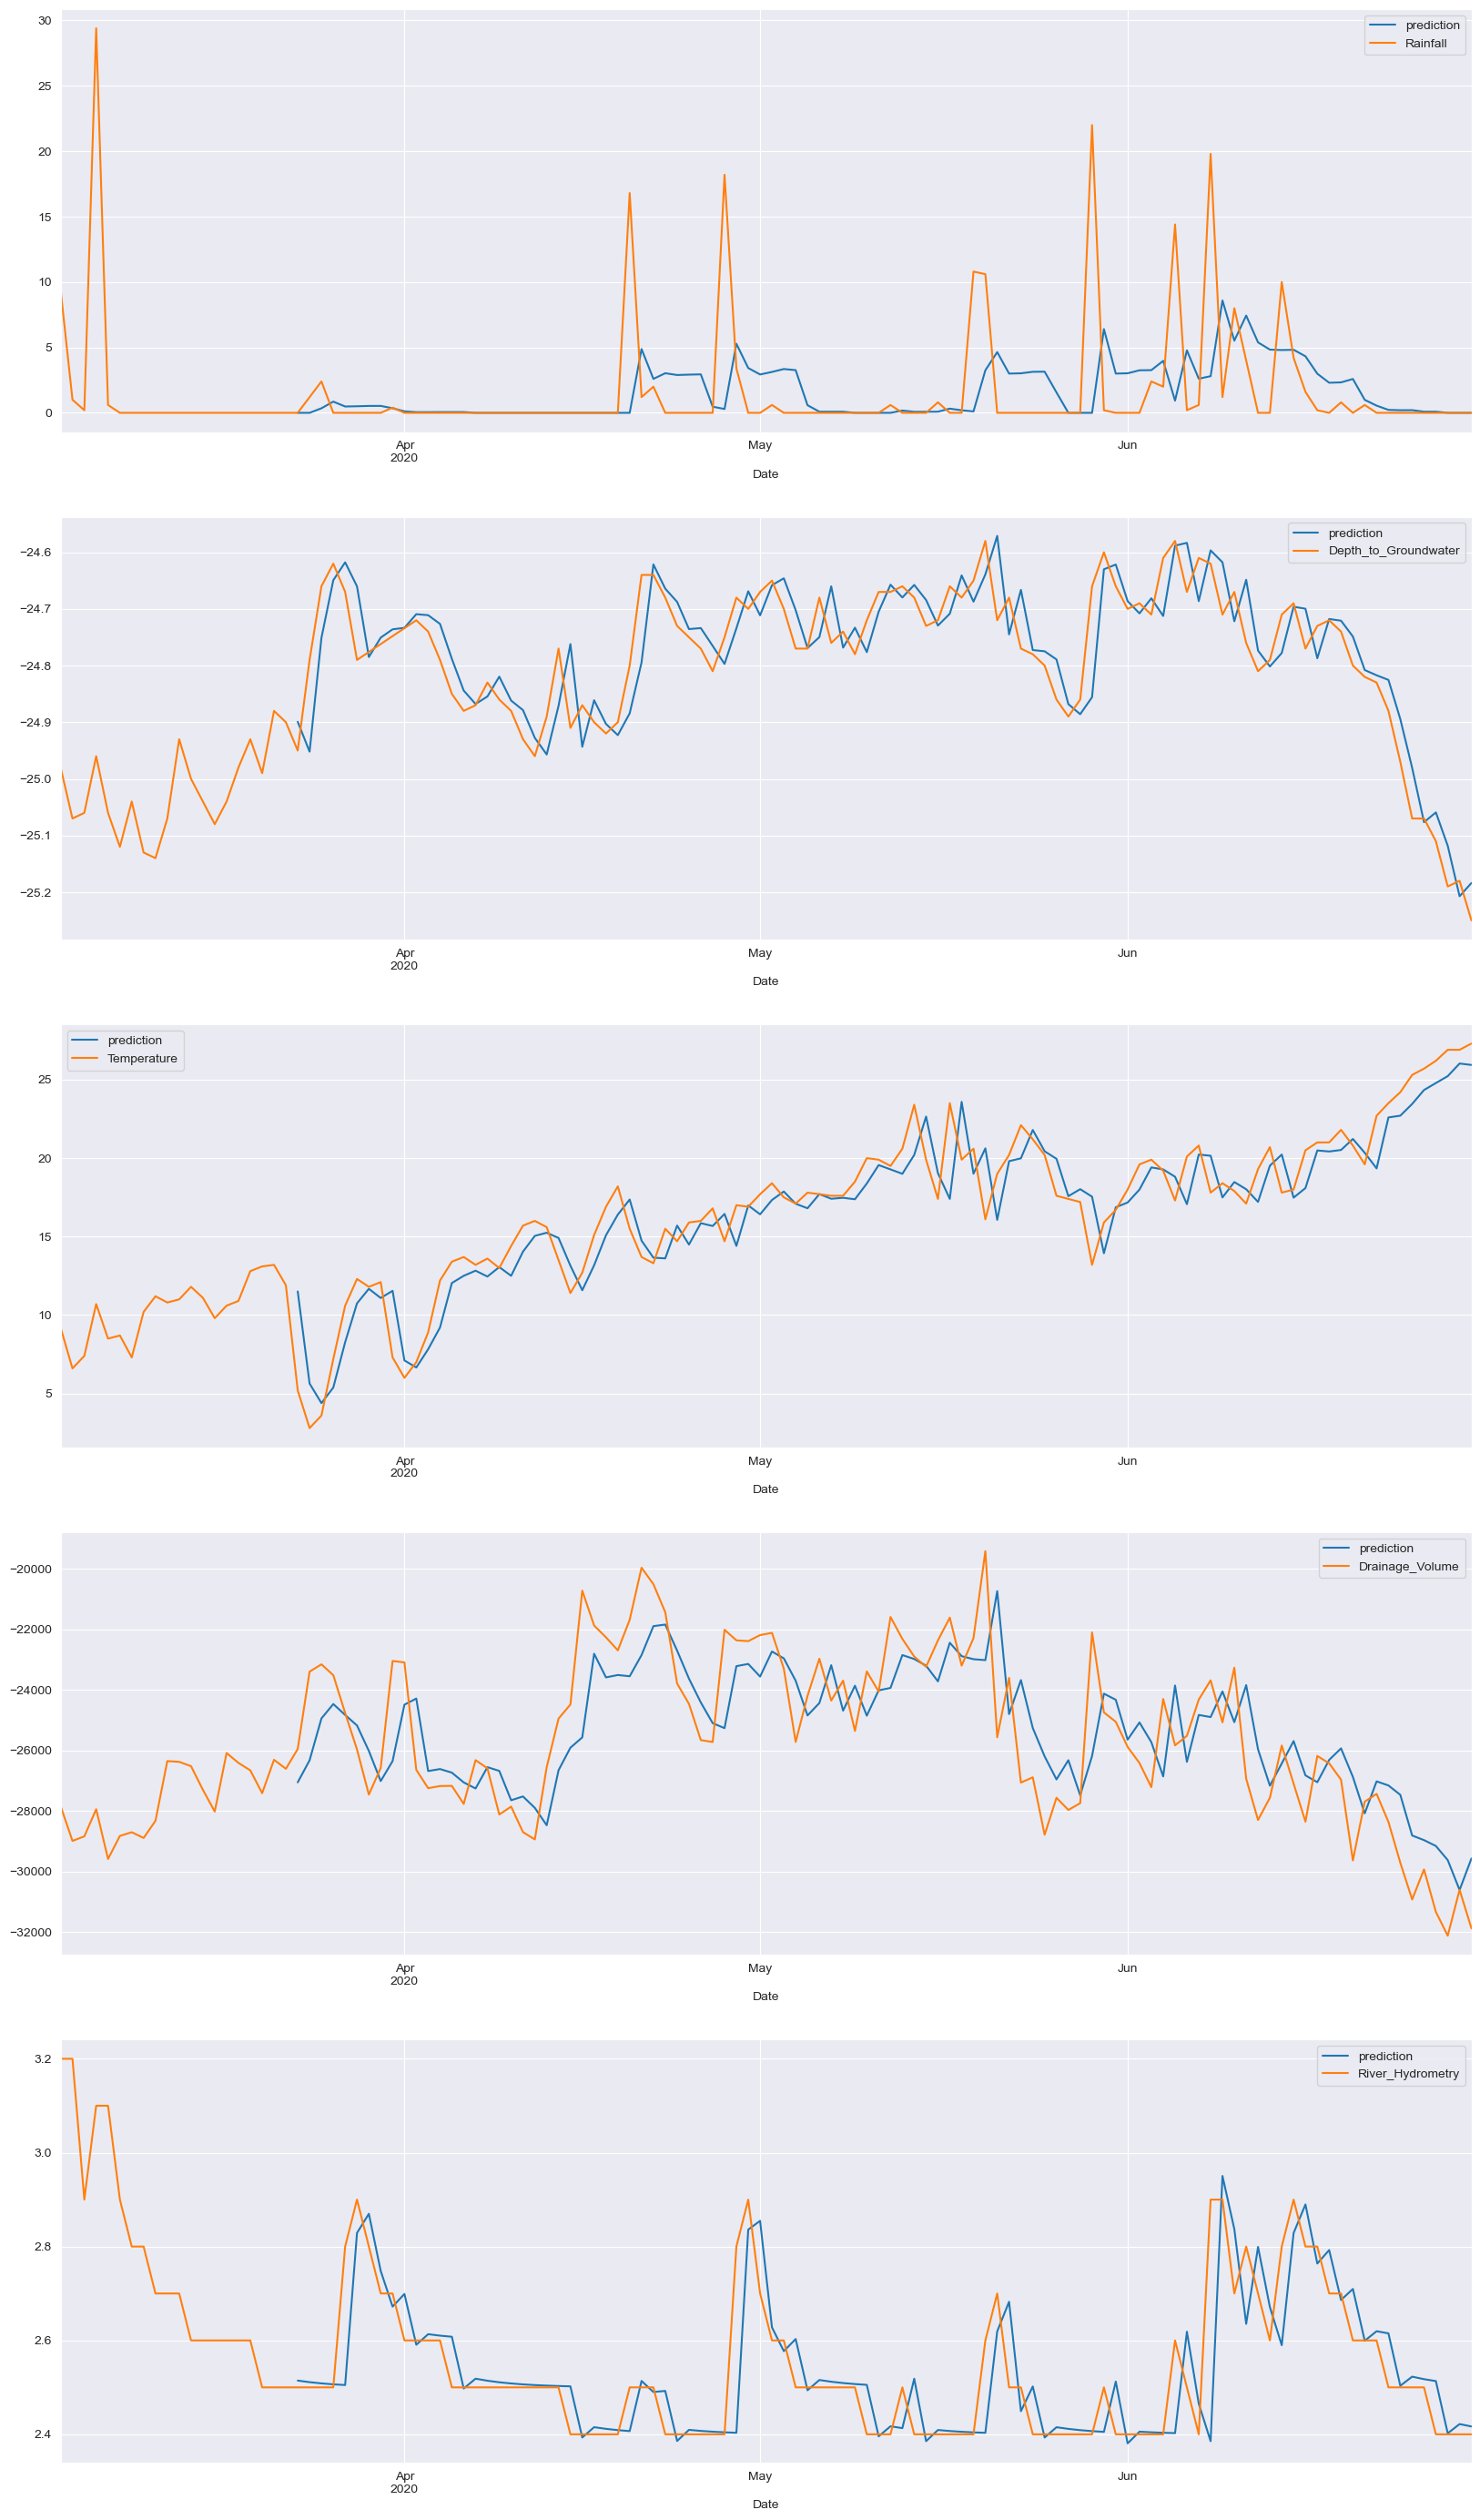

In [309]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
for i in range(5):
    saved_df.iloc[:,i].plot(ax = ax[i], label='prediction', legend=True)
    df.iloc[-120:,i].plot(ax = ax[i], legend=True)
plt.show()

In [247]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = []
for i in range(5):
    rmse.append(sqrt(mean_squared_error(saved_df.iloc[:,i],test[i])))

In [1]:
rmse

NameError: name 'rmse' is not defined

list